## **Importing libraries and datasets**

In [83]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [84]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [85]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [86]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


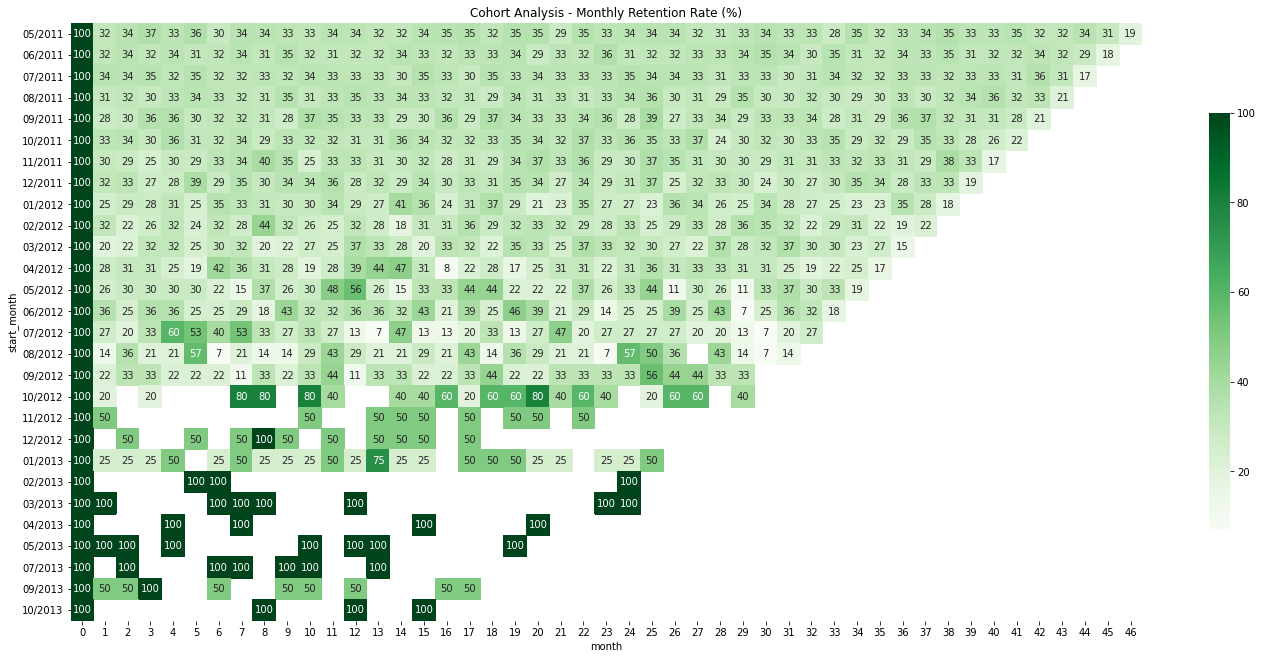

In [87]:
cohort = df_transactions.groupby(['customer_id', pd.Grouper(key='trans_date',freq='M')]).size().reset_index()
cohort['start_month'] = cohort['customer_id'].map(cohort.groupby('customer_id')['trans_date'].min())
cohort['month'] = cohort.apply(lambda x: (x['trans_date'].year - x['start_month'].year)*12 + (x['trans_date'].month - x['start_month'].month) , axis=1)
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
cohort.index = cohort.index.strftime('%m/%Y')
plt.figure(figsize=(24,11))
sns.heatmap(cohort, cmap='Greens', annot=True, fmt='.0f', cbar_kws={'shrink':.7})
# plt.yticks(cohort.index.strftime('%m/%Y'))
plt.title('Cohort Analysis - Monthly Retention Rate (%)');

## **Data Preparation**

In [88]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions=df_transactions[df_transactions['recent'] < 730]
basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])
df_transactions.head()


,customer_id,trans_date,tran_amount,recent,basket_size
1,CS4768,2015-03-15,39,2.0,M
4,CS1850,2013-11-20,78,482.0,M
5,CS5539,2014-03-26,81,356.0,L
7,CS5902,2015-01-30,89,46.0,L
9,CS3802,2013-08-20,75,574.0,M


In [89]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
del basket_size_df['size']
basket_size_df.columns = ['spend_BasketS','spend_BasketM','spend_BasketL']
df_rfm = df_rfm.join(basket_size_df)
df_rfm['spend_BasketS'] = df_rfm['spend_BasketS'].fillna(0)
df_rfm['spend_BasketM'] = df_rfm['spend_BasketM'].fillna(0)
df_rfm['spend_BasketL'] = df_rfm['spend_BasketL'].fillna(0)

In [90]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,spend_BasketS,spend_BasketM,spend_BasketL
0,CS1112,62.0,6,358,0.0,268.0,90.0
1,CS1113,36.0,11,775,0.0,316.0,459.0
2,CS1114,33.0,11,804,0.0,331.0,473.0
3,CS1115,12.0,11,831,0.0,463.0,368.0
4,CS1116,204.0,5,333,0.0,147.0,186.0


## **Calculating response rate**

In [91]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


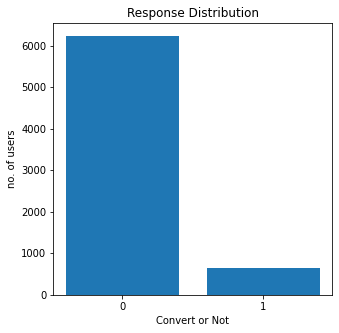

In [92]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [93]:
## merging two data sets

df_modeling = pd.merge(df_rfm,df_response)
df_modeling.head()

,customer_id,recency,frequency,monetary_value,spend_BasketS,spend_BasketM,spend_BasketL,response
0,CS1112,62.0,6,358,0.0,268.0,90.0,0
1,CS1113,36.0,11,775,0.0,316.0,459.0,0
2,CS1114,33.0,11,804,0.0,331.0,473.0,1
3,CS1115,12.0,11,831,0.0,463.0,368.0,1
4,CS1116,204.0,5,333,0.0,147.0,186.0,1


## **Creating train and test dataset**

In [94]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 6)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 6)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

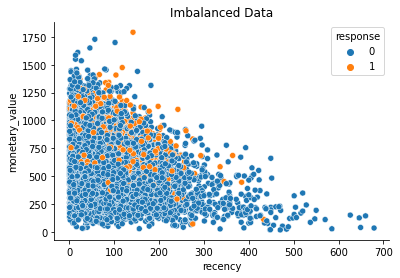

In [96]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

In [97]:
X_train

,recency,frequency,monetary_value,spend_BasketS,spend_BasketM,spend_BasketL
6590,115.0,5,232,10.0,222.0,0.0
567,8.0,14,895,0.0,595.0,300.0
2468,425.0,4,370,0.0,0.0,370.0
1149,249.0,7,428,0.0,254.0,174.0
2752,139.0,13,972,0.0,417.0,555.0
...,...,...,...,...,...,...
4931,31.0,11,747,0.0,383.0,364.0
3264,152.0,11,732,0.0,484.0,248.0
1653,13.0,17,1144,0.0,690.0,454.0
2607,7.0,7,548,0.0,199.0,349.0


## **Fixing imbalanced with Undersampling**

In [98]:
y_train

6590    0
567     0
2468    0
1149    0
2752    0
       ..
4931    0
3264    0
1653    0
2607    0
2732    0
Name: response, Length: 4818, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

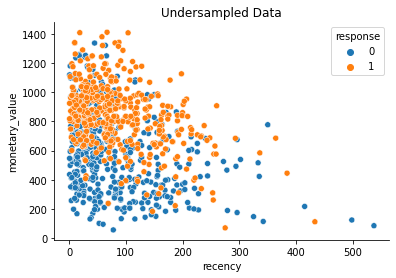

In [99]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value','spend_BasketS','spend_BasketM','spend_BasketL','response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

In [100]:
X_undersampled

array([[190.,   8., 364.,  79., 285.,   0.],
       [226.,   9., 591.,   0., 323., 268.],
       [ 30.,   8., 571.,   0., 292., 279.],
       ...,
       [ 73.,  10., 749.,   0., 305., 444.],
       [118.,  11., 740.,   0., 308., 432.],
       [233.,   4., 339.,   0., 144., 195.]])

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

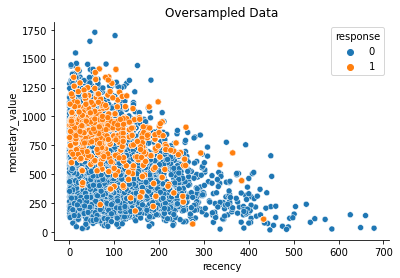

In [101]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value','spend_BasketS','spend_BasketM','spend_BasketL','response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

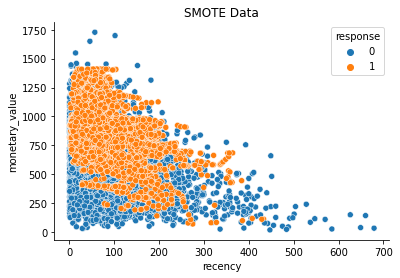

In [102]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value','spend_BasketS','spend_BasketM','spend_BasketL','response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [103]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       429
           1       0.72      0.77      0.74       429

    accuracy                           0.73       858
   macro avg       0.73      0.73      0.73       858
weighted avg       0.73      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.79      1848
           1       0.22      0.79      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.89      0.69      0.75      2066



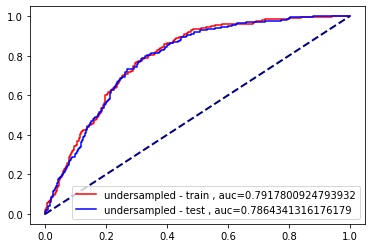

In [104]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [105]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00575922  0.21419226 -0.00088574 -0.00548024  0.00166378  0.00293071]] [-3.61902605]


In [106]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4389
           1       0.71      0.73      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.22      0.76      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.72      0.58      2066
weighted avg       0.88      0.70      0.76      2066



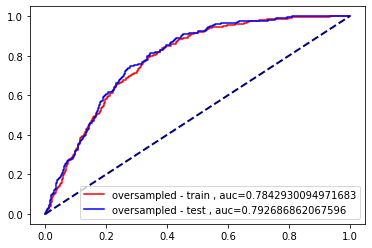

In [107]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [108]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.00682882  0.25658628 -0.0007314  -0.00478291  0.00171694  0.00233457]] [-3.61902605]


In [109]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      4389
           1       0.71      0.75      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.22      0.76      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.72      0.57      2066
weighted avg       0.88      0.70      0.75      2066



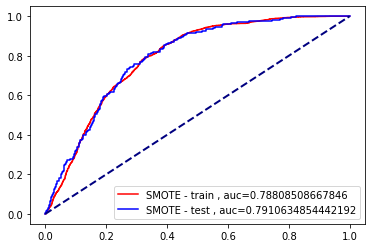

In [110]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [111]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.00634727  0.23303892 -0.00058425 -0.0050034   0.00199129  0.00242786]] [-3.61902605]


In [112]:
X_test

,recency,frequency,monetary_value,spend_BasketS,spend_BasketM,spend_BasketL
5546,28.0,7,286,25.0,261.0,0.0
3027,158.0,12,839,0.0,466.0,373.0
6234,90.0,6,336,31.0,305.0,0.0
4308,19.0,9,581,0.0,310.0,271.0
3035,25.0,11,678,0.0,504.0,174.0
...,...,...,...,...,...,...
2266,97.0,10,749,0.0,267.0,482.0
1303,42.0,13,934,0.0,391.0,543.0
474,74.0,4,322,0.0,41.0,281.0
1789,191.0,8,561,0.0,290.0,271.0


## **XGBoost**

In [113]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.778878
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.784967
[2]	validation_0-auc:0.794201
[3]	validation_0-auc:0.795137
[4]	validation_0-auc:0.797222
[5]	validation_0-auc:0.796989
[6]	validation_0-auc:0.795496
[7]	validation_0-auc:0.794237
[8]	validation_0-auc:0.795816
[9]	validation_0-auc:0.79789
[10]	validation_0-auc:0.797018
[11]	validation_0-auc:0.798465
[12]	validation_0-auc:0.798052
[13]	validation_0-auc:0.799293
[14]	validation_0-auc:0.798622
[15]	validation_0-auc:0.798758
[16]	validation_0-auc:0.801198
[17]	validation_0-auc:0.800924
[18]	validation_0-auc:0.799479
[19]	validation_0-auc:0.799818
[20]	validation_0-auc:0.799442
[21]	validation_0-auc:0.799635
Stopping. Best iteration:
[16]	validation_0-auc:0.801198

training set
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       429
           1       0.73      0.84      0.78       429

  

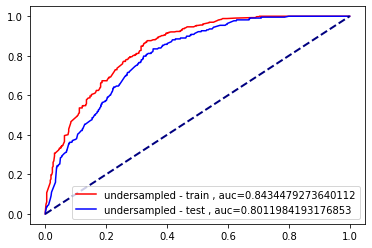

In [114]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

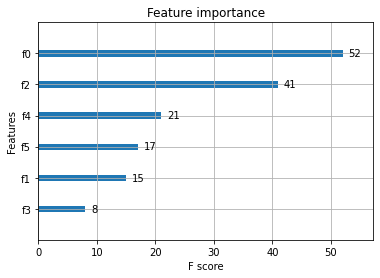

In [115]:
xgb.plot_importance(xgb_model_under)

In [116]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.793122
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.793721
[2]	validation_0-auc:0.794978
[3]	validation_0-auc:0.798048
[4]	validation_0-auc:0.796685
[5]	validation_0-auc:0.799757
[6]	validation_0-auc:0.798117
[7]	validation_0-auc:0.798356
[8]	validation_0-auc:0.802265
[9]	validation_0-auc:0.803504
[10]	validation_0-auc:0.804504
[11]	validation_0-auc:0.803287
[12]	validation_0-auc:0.803359
[13]	validation_0-auc:0.803123
[14]	validation_0-auc:0.803502
[15]	validation_0-auc:0.802696
Stopping. Best iteration:
[10]	validation_0-auc:0.804504

training set
              precision    recall  f1-score   support

           0       0.81      0.66      0.72      4389
           1       0.71      0.84      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              pr

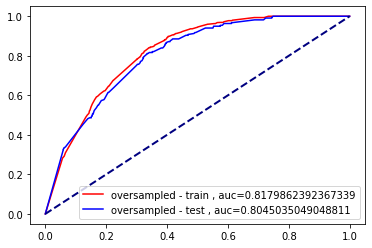

In [117]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

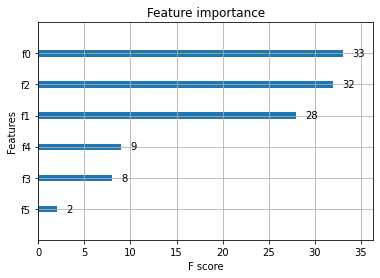

In [118]:
xgb.plot_importance(xgb_model_over)

In [119]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.787194
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.791824
[2]	validation_0-auc:0.790752
[3]	validation_0-auc:0.792182
[4]	validation_0-auc:0.79362
[5]	validation_0-auc:0.797411
[6]	validation_0-auc:0.797232
[7]	validation_0-auc:0.793587
[8]	validation_0-auc:0.794254
[9]	validation_0-auc:0.794406
[10]	validation_0-auc:0.791808
Stopping. Best iteration:
[5]	validation_0-auc:0.797411

training set
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      4389
           1       0.72      0.85      0.78      4389

    accuracy                           0.76      8778
   macro avg       0.77      0.76      0.75      8778
weighted avg       0.77      0.76      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1848
           1       0.22      0.81      0.35       218

    accuracy   

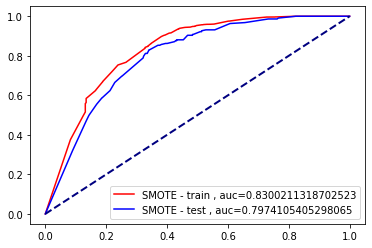

In [120]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

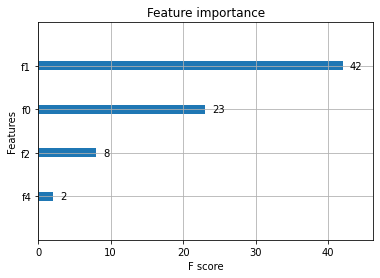

In [121]:
xgb.plot_importance(xgb_model_SMOTE)

In [122]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.750048
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.758605
[2]	validation_0-auc:0.775522
[3]	validation_0-auc:0.777847
[4]	validation_0-auc:0.77878
[5]	validation_0-auc:0.773551
[6]	validation_0-auc:0.776439
[7]	validation_0-auc:0.774639
[8]	validation_0-auc:0.773093
[9]	validation_0-auc:0.770849
Stopping. Best iteration:
[4]	validation_0-auc:0.77878

training set
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      4389
           1       0.71      0.87      0.78      4389

    accuracy                           0.76      8778
   macro avg       0.77      0.76      0.76      8778
weighted avg       0.77      0.76      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      1848
           1       0.21      0.76      0.33       218

    accuracy                